# Julia Academy

## Data Science Course

# 3. Some Basic Statistics in Julia

**Huda Nassar**

**Source:** https://github.com/JuliaAcademy/DataScience/blob/main/03.%20Statistics.ipynb

Data science operations rely on us understanding and using statistics. Here we will explore how statistics computations and operations are handled in Julia

We will use a [classic statistics dataset - the Old Faithful geyser eruptions](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/faithful.html) in Yellowstone National Park.

In [1]:
using Statistics
using StatsBase
using RDatasets
using Plots
using StatsPlots
using KernelDensity
using Distributions
using LinearAlgebra
using HypothesisTests
using PyCall
using MLBase

#### Old Faithful Eruptions

In [2]:
data = dataset("datasets","faithful")
data

,Eruptions,Waiting
,Float64,Int64
1,3.6,79
2,1.8,54
3,3.333,74
4,2.283,62
5,4.533,85
6,2.883,55
7,4.7,88
8,3.6,85
9,1.95,51


Let's do a quick scatterplot of the two variables (which are both measured in minutes) for every record

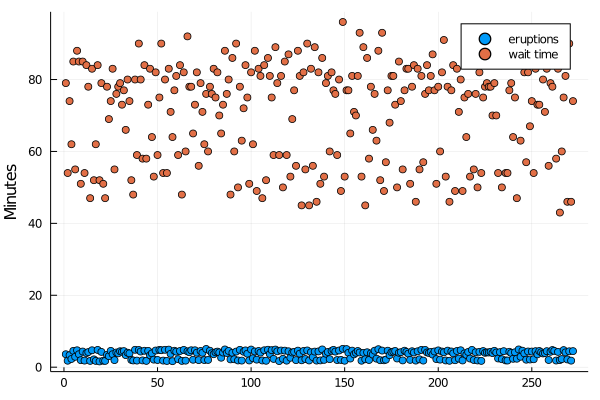

In [3]:
eruptions = data[!,:Eruptions]
scatter(eruptions,label="eruptions")
waittime = data[!,:Waiting]
scatter!(waittime,label="wait time")
ylabel!("Minutes")

This plot as is tells us very little. However we can explore this dataset more to understand the signals better.

#### Distribution Plots

One way of visually summarizing a distribution is to use a box-and-whiskers plot. It gives a rough representation of the skewness and centre of mass of the data:

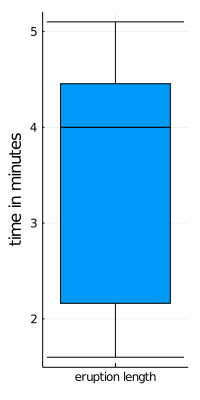

In [4]:
boxplot(["eruption length"],
        eruptions, 
        legend=false,
        size=(200,400),
        whisker_width=1,
        ylabel="time in minutes")

The box plot shows us that the median is around 4 minutes.

If we wanted a more complete view of the distribution, we can use a discrete representation called a histogram:

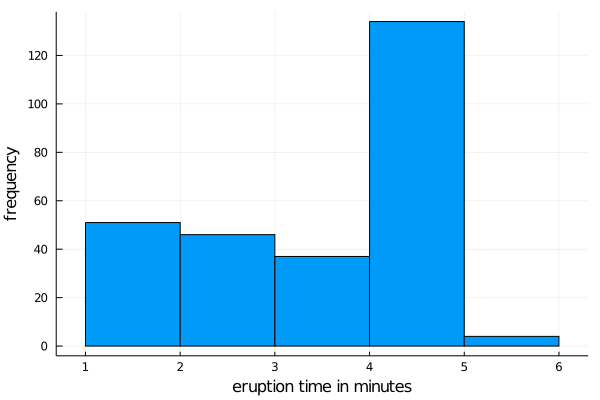

In [12]:
histogram(eruptions, xlabel="eruption time in minutes", ylabel="frequency", label=nothing)

The issue with this histogram is that the bins are two wide which is hiding information from us. Now in Julia, the `histogram` function has automatic way of deciding a good number of bins. One method is the [square root choice](https://en.wikipedia.org/wiki/Histogram#Square-root_choice):

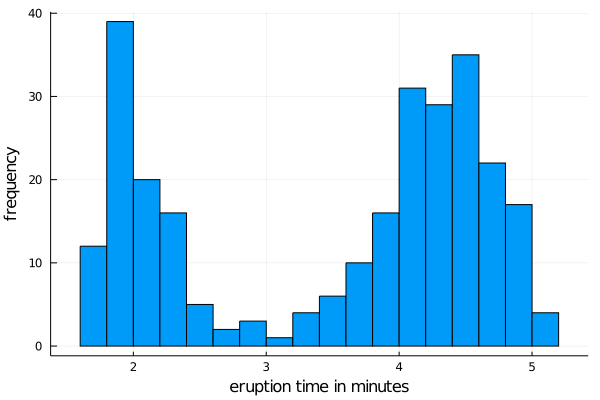

In [13]:
histogram(eruptions,
          bins=:sqrt,
          xlabel="eruption time in minutes", 
          ylabel="frequency", 
          label=nothing)

Now we can see that the distribution is in fact bi-modal. Even then, the histogram can be misleading so what we can do is let the number of bins tend to infinity (equivalent binwidth tend to zero). To we can approximate the resulting function using a "kernel density estimate" which shows the smoother variation in density of the .

In [14]:
p = kde(eruptions);

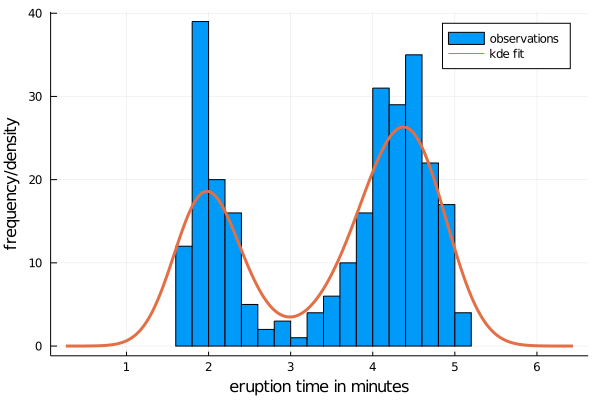

In [18]:
histogram(eruptions,
          bins=:sqrt,
          xlabel="eruption time in minutes", 
          label="observations")
plot!(p.x, p.density .* length(eruptions) .*0.2,   # the kde fit and histogram have different units of measures, so we need to align them for visualisation
      linewidth=3,
      color=2,
      label="kde fit")
ylabel!("frequency/density")

### Probability Distributions

`Distributions.jl` provides an extremely nice and powerful interface for working with probability distributions. We can generate samples from a number of known distributions

In [20]:
d = Normal()
random_vector = rand(d, 100000);

In [21]:
p = kde(random_vector);

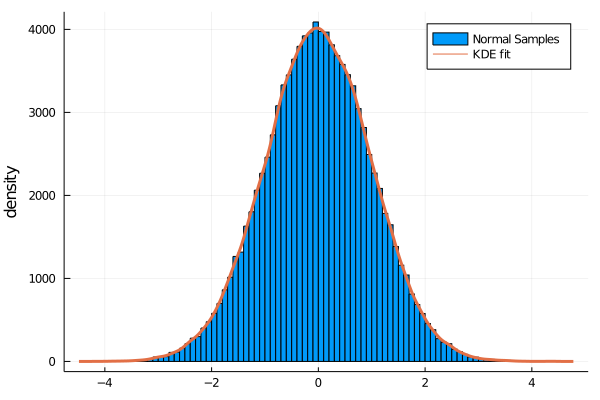

In [23]:
histogram(random_vector, label="Normal Samples")
plot!(p.x, p.density .* length(random_vector) .*0.1, 
      linewidth=3, color=2, label="KDE fit")
ylabel!("density")

We can also play a game and fit a uniformaly sample vector to a normal distribution:

In [27]:
x = rand(1000)
d = fit(Normal, x)
samples = rand(d, 1000);

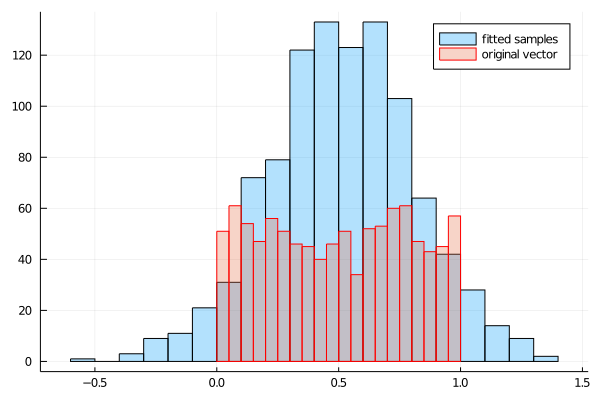

In [28]:
histogram(samples, nbins=20, fillalpha=0.3, label="fitted samples")
histogram!(x, nbins=20, linecolor=:red, fillalpha=0.3, label="original vector")

What if we try to fit a normal distribution to the eruptions (we know that eruptions are bimodal but let's see anyway)

In [30]:
d = fit(Normal, eruptions)
fitted_samples=rand(d, 1000);

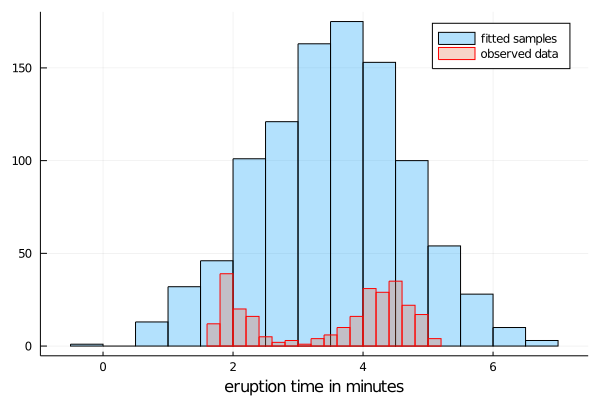

In [32]:
histogram(fitted_samples, nbins=20, fillalpha=0.3, label="fitted samples")
histogram!(eruptions, nbins=20, linecolor=:red, fillalpha=0.3, label="observed data")
xlabel!("eruption time in minutes")

We can see that the normal distribution is not a good fit, but luckily there are other ways.

### Hypothesis Testing

We can do hypothesis testing using the `HypothesisTests.jl` package.

In [33]:
random_vector = rand(1000);

Does our random vector fit a normal distribution?

In [35]:
OneSampleTTest(random_vector)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.487581
    95% confidence interval: (0.4695, 0.5056)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   1000
    t-statistic:              53.0200861758477
    degrees of freedom:       999
    empirical standard error: 0.009196151362246337


And we would accept if we use a normally sampled random vector

In [36]:
random_vector = randn(1000)
OneSampleTTest(random_vector)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.0103694
    95% confidence interval: (-0.0535, 0.0742)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7500

Details:
    number of observations:   1000
    t-statistic:              0.3186688732621362
    degrees of freedom:       999
    empirical standard error: 0.032539761165036526


Does the Old Faithful eruptions data fit a normal distribution?

In [37]:
OneSampleTTest(eruptions)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          3.48778
    95% confidence interval: (3.3515, 3.624)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   272
    t-statistic:              50.39726752574924
    degrees of freedom:       271
    empirical standard error: 0.06920579744632577


### Correlations

Let's finally look at the two variables in the Old Faithful dataset together. Below we can calculate to common correlation coefficients:

In [38]:
# Pearson's Correlation Coefficient
cor(eruptions, waittime)

0.9008111683218133

In [39]:
# Spearman's Correlation Coefficient
corspearman(eruptions, waittime)

0.7779720576516121

We can also visualize correlations using a scatterplot:

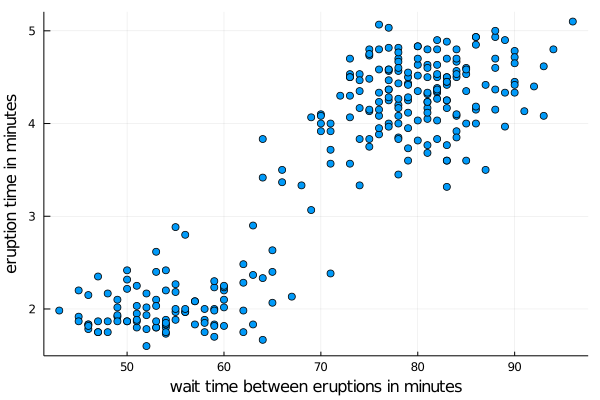

In [40]:
scatter(waittime, eruptions, legend=false)
xlabel!("wait time between eruptions in minutes")
ylabel!("eruption time in minutes")

We see the positive slope as expected from the correlation coefficients.

This means that the the longer the wait time between eruptions, the longer the length of the eruption itself. 

### AUC and Confusion Matrix

Finally let's cover some basic metrics for categorical data using the `MLBase.jl` package which provides useful for functions for supporting machine learning algorithms.

In [44]:
ground_truth = [1, 1, 1, 1, 1, 1, 1, 2]
pred = [1, 1, 2, 2, 1, 1, 1, 1];

In [46]:
confusion_matrix = confusmat(2, ground_truth, pred)

2×2 Array{Int64,2}:
 5  2
 1  0

So we see 5 true positives, one false positive, 2 false negatives and no true negatives

### Receiver Operator Characteristics

The ROC curve shows the relationship between the sensitivity (% true positives) and specificity (% true negatives). We know that there is a tradeoff between the two as a classifier which tends to output positive will have higher sensitivity and lower specificity and vice-versa.

In [47]:
gt = [1, 1, 1, 1, 1, 1, 1, 0];
pred = [1, 1, 0, 0, 1, 1, 1, 1]

ROC = MLBase.roc(gt,pred)

ROCNums{Int64}
  p = 7
  n = 1
  tp = 5
  tn = 0
  fp = 1
  fn = 2


In machine learning, we use "precision" and "recall" to measure:

- Recall: TP / P ie. how good is the classifier at recognizing the original true positives (equivalent to sensitivity)

In [49]:
precision(ROC)

0.8333333333333334

- Precision: TP / (TP  + FP) ie. how good is the classifier at distinguishing between true positives and false positives.

In [51]:
recall(ROC)

0.7142857142857143